In [1]:
'''
Sources::::: 
https://www.digitalocean.com/community/tutorials/how-to-perform-sentiment-analysis-in-python-3-using-the-natural-language-toolkit-nltk
https://www.tutorialspoint.com/matplotlib/matplotlib_bar_plot.htm

https://textblob.readthedocs.io/en/dev/quickstart.html#wordnet-integration -- spell check, word counts.
http://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm -- 

'''

'\nSources::::: \nhttps://www.digitalocean.com/community/tutorials/how-to-perform-sentiment-analysis-in-python-3-using-the-natural-language-toolkit-nltk\nhttps://www.tutorialspoint.com/matplotlib/matplotlib_bar_plot.htm\n\nhttps://textblob.readthedocs.io/en/dev/quickstart.html#wordnet-integration -- spell check, word counts.\nhttp://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm -- \n\n'

In [44]:
import nltk, re, string, random
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
nltk.download('twitter_samples')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.corpus import twitter_samples, stopwords
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import FreqDist, classify, NaiveBayesClassifier
from WNAffect import wnaffect,emotion
from Lexicon import Lexicon
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import json
from progressbar import ProgressBar

[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\SIDDHARTHA\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\SIDDHARTHA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\SIDDHARTHA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\SIDDHARTHA\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SIDDHARTHA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [45]:
def lemmatize_sentence(tokens):
    '''
    lemmatizing words, for e.g 'run', 'ran', 'running' is the same word.
    The lemmatizer conforms similar words to an equivalent form, or is transformed to its root form
    '''
    lemmatizer = WordNetLemmatizer()
    lemmatized_sentence = []
    for word, tag in pos_tag(tokens):
        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
        lemmatized_sentence.append(lemmatizer.lemmatize(word, pos))
    return lemmatized_sentence

def remove_noise(tweet_tokens, stop_words = ()):
    '''
    Removing stop words like 'is', 'the' etc. lemmatize_sentence() function implementation is 
    reused here.
    '''
    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        token = re.sub("(@[A-Za-z0-9_]+)","", token)

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

def get_all_words(cleaned_tokens_list):
    for tokens in cleaned_tokens_list:
        for token in tokens:
            yield token

def get_tweets_for_model(cleaned_tokens_list):
    for tweet_tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tweet_tokens)

In [18]:
positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')
#text = twitter_samples.strings('tweets.20150430-223406.json')


#with open('sample_tweets.json','w') as outfile:
#    json.dump(positive_tweets,outfile)
positive_tweet_tokens = twitter_samples.tokenized('positive_tweets.json')
negative_tweet_tokens = twitter_samples.tokenized('negative_tweets.json')
print(positive_tweets[0])
print(positive_tweet_tokens[0])

#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)
['#FollowFriday', '@France_Inte', '@PKuchly57', '@Milipol_Paris', 'for', 'being', 'top', 'engaged', 'members', 'in', 'my', 'community', 'this', 'week', ':)']


In [46]:
from TwitterManager import TwitterManager
tweety_after=TwitterManager.TwitterManager('C:\\Users\\SIDDHARTHA\\Trinity\\TextAnalysis\\TextAnalysis\\Sentimentalysis\\tweets_after.csv')
tweets_list_after=tweety_after.get_tweets_list()
tweet_tokens_after=tweety_after.tokenize(tweets_list_after)
print(len(tweet_tokens_after))

954


In [47]:
tweety_before=TwitterManager.TwitterManager('C:\\Users\\SIDDHARTHA\\Trinity\\TextAnalysis\\TextAnalysis\\Sentimentalysis\\tweets_before.csv')
tweets_list_before=tweety_before.get_tweets_list()
tweet_tokens_before=tweety_before.tokenize(tweets_list_before)
print(len(tweet_tokens_before))

5339


In [49]:
after_cleaned_tokens_list = []
before_cleaned_tokens_list = []
stop_words = stopwords.words('english')

for tokens in tweet_tokens_after:
    after_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

for tokens in tweet_tokens_before:
    before_cleaned_tokens_list.append(remove_noise(tokens, stop_words))


print(len(after_cleaned_tokens_list))
print(len(before_cleaned_tokens_list))

954
5339


In [38]:
all_after_words = get_all_words(after_cleaned_tokens_list)
all_before_words = get_all_words(before_cleaned_tokens_list)
freq_dist_after = FreqDist(all_after_words)
freq_dist_before = FreqDist(all_before_words)

#print(positive_cleaned_tokens_list[1])
#print(positive_cleaned_tokens_list[2])

#print(freq_dist_pos.most_common(10))
#print(freq_dist_neg.most_common(10))

In [39]:
'''
For after words!
'''


from Lexicon import Lexicon
after_tokens_for_model = get_tweets_for_model(after_cleaned_tokens_list)
before_tokens_for_model = get_tweets_for_model(before_cleaned_tokens_list)

#wna = WNAffect.WNAffect('wordnet-1.6/', 'wn-domains-3.2/')
#wna = wnaffect.WNAffect('wordnet-1.6/', 'wn-domains-3.2/')
#emo = wna.get_emotion('Kill','NN')
#print(emo)


emotion_fetcher = Lexicon.Lexicon("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/NRC-Sentiment-Emotion-Lexicons/NRC-Sentiment-Emotion-Lexicons/NRC-Emotion-Lexicon-v0.92/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt")
#print(emotion_fetcher.get_emotion("shout"))
emotions_count_dict = {"anger":0,"anticipation":0,"disgust":0,"fear":0,"joy":0,"negative":0,"positive":0,"sadness":0,"surprise":0,"trust":0,"unclassified":0}


pos_count=0
emotions_list=[]
pos_word_list=[]
for tweet_dict in after_tokens_for_model:
    for word,tag in pos_tag(tweet_dict):
        pos_word_list.append(word)
    pos_count+=1

for word in pos_word_list:
    for sentiment in emotion_fetcher.get_emotion(word):
        emotions_count_dict[sentiment]+=1


print(emotions_count_dict)
print(pos_count)

{'anger': 304, 'anticipation': 448, 'disgust': 150, 'fear': 269, 'joy': 325, 'negative': 538, 'positive': 1016, 'sadness': 281, 'surprise': 286, 'trust': 742, 'unclassified': 0}
954


In [40]:
'''
for negative words
'''
from Lexicon import Lexicon
#positive_tokens_for_model = get_tweets_for_model(positive_cleaned_tokens_list)
#negative_tokens_for_model = get_tweets_for_model(negative_cleaned_tokens_list)

#wna = WNAffect.WNAffect('wordnet-1.6/', 'wn-domains-3.2/')
#wna = wnaffect.WNAffect('wordnet-1.6/', 'wn-domains-3.2/')
#emo = wna.get_emotion('Kill','NN')
#print(emo)


emotion_fetcher = Lexicon.Lexicon("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/NRC-Sentiment-Emotion-Lexicons/NRC-Sentiment-Emotion-Lexicons/NRC-Emotion-Lexicon-v0.92/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt")
#print(emotion_fetcher.get_emotion("shout"))
emotions_count_dict = {"anger":0,"anticipation":0,"disgust":0,"fear":0,"joy":0,"negative":0,"positive":0,"sadness":0,"surprise":0,"trust":0,"unclassified":0}


neg_count=0
emotions_list=[]
neg_word_list=[]
for tweet_dict in before_tokens_for_model:
    for word,tag in pos_tag(tweet_dict):
        neg_word_list.append(word)
    neg_count+=1

for word in neg_word_list:
    for sentiment in emotion_fetcher.get_emotion(word):
        emotions_count_dict[sentiment]+=1


print(emotions_count_dict)
print(neg_count)

{'anger': 2296, 'anticipation': 3044, 'disgust': 1185, 'fear': 2116, 'joy': 2208, 'negative': 4152, 'positive': 6303, 'sadness': 2443, 'surprise': 1872, 'trust': 4092, 'unclassified': 0}
5339


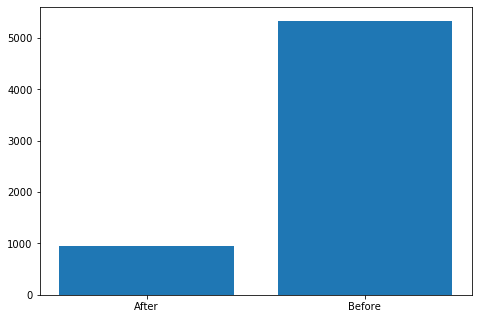

In [41]:
fig = plt.figure()
tweet_type = ['After','Before']
tweet_counts = [pos_count,neg_count]
ax = fig.add_axes([0,0,1,1])
ax.bar(tweet_type,tweet_counts)
plt.show()

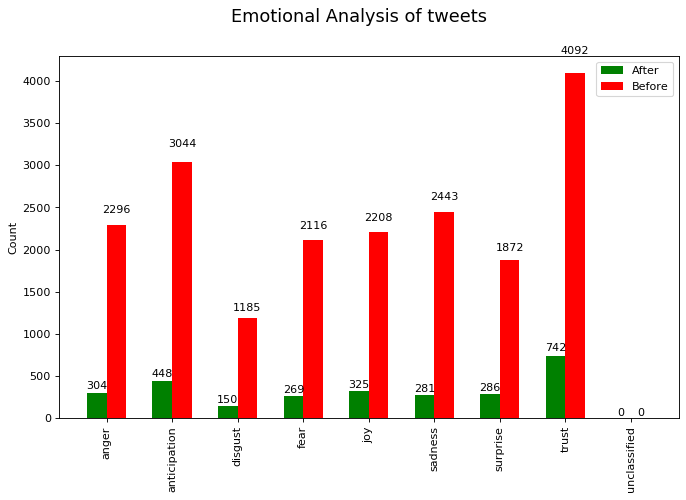

In [43]:

emotions_pos = {'anger': 304, 'anticipation': 448, 'disgust': 150, 'fear': 269, 'joy': 325, 'sadness': 281, 'surprise': 286, 'trust': 742, 'unclassified': 0}

emotions_neg = {'anger': 2296, 'anticipation': 3044, 'disgust': 1185, 'fear': 2116, 'joy': 2208,'sadness': 2443, 'surprise': 1872, 'trust': 4092, 'unclassified': 0}

emotions_colors = {'anger': 'red', 'anticipation': 'purple', 'disgust': 'yellow', 'fear': 'indigo', 'joy': 'green', 'negative': 'black', 'positive': 'pink', 'sadness': 'blue', 'surprise': 'maroon', 'trust': 'orange', 'unclassified': 'cyan'}
#labels = list(emotions_colors.keys())
#handles = [plt.Rectangle((1,1),1,1, color=emotions_colors[label]) for label in labels]
my_cmap = cm.get_cmap('jet')
ind = np.arange(len(emotions_pos))
width=0.3
fig = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
fig.suptitle('Emotional Analysis of tweets', fontsize=16)
ax = fig.add_subplot(111)
pos_bars=ax.bar(ind, list(emotions_pos.values()),width,color='g',align='center')
neg_bars=ax.bar(ind+width, list(emotions_neg.values()),width,color='r', align='center')
ax.set_ylabel('Count')
ax.set_xticklabels(list(emotions_pos.keys()), rotation=90)
ax.set_xticks(ind+width/2)
ax.legend( (pos_bars[0], neg_bars[0]), ('After', 'Before') )

def autolabel(bars):
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x()+bar.get_width()/2., 1.05*h, '%d'%int(h),
                ha='center', va='bottom')

autolabel(pos_bars)
autolabel(neg_bars)

plt.show()

In [20]:
positive_dataset = [(tweet_dict, "Positive")
                     for tweet_dict in positive_tokens_for_model]

print(positive_dataset)
print(negative_dataset)

negative_dataset = [(tweet_dict, "Negative")
                     for tweet_dict in negative_tokens_for_model]

dataset = positive_dataset + negative_dataset

random.shuffle(dataset)

#70:30 split
train_data = dataset[:7000]
test_data = dataset[7000:]   

print(train_data)
print(test_data)

'xx': True}, 'Positive'), ({'bed': True, 'best': True, 'couple': True, 'ever': True, ':)': True}, 'Positive'), ({'favorite': True, 'apple': True, 'sauce': True, ':)': True}, 'Positive'), ({'nice': True, 'holiday': True, 'honey': True, ':-)': True, 'kisses': True}, 'Positive'), ({'follow': True, 'back': True, 'pleasse': True, ':)': True}, 'Positive'), ({'thakyou': True, 'sir': True, ':)': True}, 'Positive'), ({'thank': True, 'beatriz': True, ':)': True}, 'Positive'), ({'rt': True, 'bailona': True, 'group': True, 'chat': True, 'mention': True, 'approve': True, 'fanbase': True, ':)': True}, 'Positive'), ({'party': True, 'cancel': True, ':p': True, '#bajrangibhaijaanhighestweek1': True}, 'Positive'), ({'thanks': True, 'follow': True, ':-)': True, 'hope': True, 'great': True, 'week': True}, 'Positive'), ({'puff': True, 'pastry': True, 'egg': True, 'tart': True, 'hot': True, 'fresh': True, 'oven': True, ':)': True, 'wan': True, 'chai': True, 'mtr': True}, 'Positive'), ({'thank': True, 'follo

NameError: name 'negative_dataset' is not defined

In [ ]:
classifier = NaiveBayesClassifier.train(train_data)

In [ ]:
print("Accuracy is:", classify.accuracy(classifier, test_data))
print(classifier.show_most_informative_features(10))